[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/lymphoma-classification/blob/master/3_binary_classification.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/mbarbetti/lymphoma-classification/blob/master/3_binary_classification.ipynb)

# Binary classification

## Data loading and preparation

In [1]:
import numpy as np
import pandas as pd

import os
import pickle

data_dir  = "./data"
data_file = "db_mediastinalbulky_v2-reduced.pkl" 
file_path = os.path.join ( data_dir, data_file )

with open (file_path, "rb") as file:
  data = pickle.load (file)

data . info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 118
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               119 non-null    float64
 1   lymphoma_type                    119 non-null    float64
 2   age                              111 non-null    float64
 3   SUVmin (SUV)                     111 non-null    float64
 4   SUVmean (SUV)                    111 non-null    float64
 5   MTV (# vx)                       111 non-null    float64
 6   SMTV (mL/Kg) TOT                 111 non-null    float64
 7   CONVENTIONAL_SUVbwmin            115 non-null    float64
 8   CONVENTIONAL_SUVbwKurtosis       115 non-null    float64
 9   DISCRETIZED_HISTO_Kurtosis       110 non-null    float64
 10  SHAPE_Sphericity[onlyFor3DROI])  113 non-null    float64
 11  GLCM_Correlation                 113 non-null    float64
 12  GLRLM_SRE             

### Aggressive data cleaning 

In [2]:
data . dropna ( inplace = True )
data . info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 118
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               101 non-null    float64
 1   lymphoma_type                    101 non-null    float64
 2   age                              101 non-null    float64
 3   SUVmin (SUV)                     101 non-null    float64
 4   SUVmean (SUV)                    101 non-null    float64
 5   MTV (# vx)                       101 non-null    float64
 6   SMTV (mL/Kg) TOT                 101 non-null    float64
 7   CONVENTIONAL_SUVbwmin            101 non-null    float64
 8   CONVENTIONAL_SUVbwKurtosis       101 non-null    float64
 9   DISCRETIZED_HISTO_Kurtosis       101 non-null    float64
 10  SHAPE_Sphericity[onlyFor3DROI])  101 non-null    float64
 11  GLCM_Correlation                 101 non-null    float64
 12  GLRLM_SRE             

### Input/output preparation

In [3]:
cols = list ( data.columns )
X_cols = cols[2:]
y_cols = "lymphoma_type"

X = data[X_cols] . to_numpy()
y = data[y_cols] . to_numpy() . flatten()
y = ( y != 1 )   # Hodgkin/non-Hodgkin classification

ratio = len(y[y == True]) / len(y[y == False])
print ( "NHL-HL ratio on data-set : {:.1f}%" . format (100 * ratio) )

NHL-HL ratio on data-set : 55.4%


### Train-set and test-set splitting

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split ( X, y, test_size = 0.2, random_state = 42 )

### Train-set
ratio_train = len(y_train[y_train == True]) / len(y_train[y_train == False])
print ( "NHL-HL ratio on train-set : {:.1f}%" . format (100 * ratio_train) )

### Test-set
ratio_test = len(y_test[y_test == True]) / len(y_test[y_test == False])
print ( "NHL-HL ratio on test-set  : {:.1f}%" . format (100 * ratio_test) )

NHL-HL ratio on train-set : 53.8%
NHL-HL ratio on test-set  : 61.5%


In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit ( n_splits = 1, test_size = 0.2, random_state = 42 )
for idx_train, idx_test in sss . split ( X, y ):
  X_train , y_train = X[idx_train] , y[idx_train]
  X_test  , y_test  = X[idx_test]  , y[idx_test]

### Train-set
ratio_train = len(y_train[y_train == True]) / len(y_train[y_train == False])
print ( "NHL-HL ratio on train-set : {:.1f}%" . format (100 * ratio_train) )

### Test-set
ratio_test = len(y_test[y_test == True]) / len(y_test[y_test == False])
print ( "NHL-HL ratio on test-set  : {:.1f}%" . format (100 * ratio_test) )

NHL-HL ratio on train-set : 56.9%
NHL-HL ratio on test-set  : 50.0%


## Data preprocessing

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer

#scaler = MinMaxScaler()
scaler = StandardScaler()
#scaler = QuantileTransformer (n_quantiles = 50, output_distribution = "normal")

X_train = scaler . fit_transform ( X_train )
X_test  = scaler . transform ( X_test )

np.mean ( X_train, axis = 0 )

array([ 1.14491749e-16,  1.31838984e-17,  7.40726924e-17, -3.98986399e-17,
        2.49800181e-17,  6.82093271e-16, -1.02695630e-16, -3.05311332e-17,
        7.20257187e-16,  2.49800181e-16, -6.64954203e-15, -6.59194921e-17,
        1.03528297e-15,  7.66747776e-17,  3.04443970e-17, -1.68615122e-16,
       -1.81105131e-16])

## Baseline: Dummy Classifier

In [7]:
from sklearn.dummy import DummyClassifier
clf_dummy = DummyClassifier (strategy = "stratified")

from sklearn.model_selection import cross_val_score
accuracy = cross_val_score ( clf_dummy, X_train, y_train, scoring = "accuracy", cv = 3 )

from utils import display_score
display_score ( scores = accuracy, score_name = "accuracy", model_name = "Dummy Classifier" )

+--------------------+
|  Dummy Classifier  |
+--------------------+
| accuracy : [0.51851852 0.55555556 0.61538462]
| mean : 56.3%
| std  : 4.0%
+--- - -


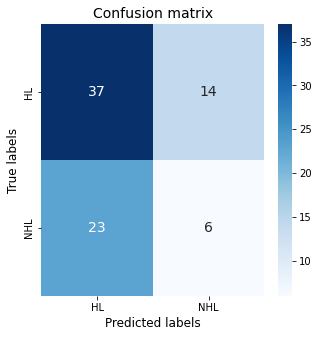

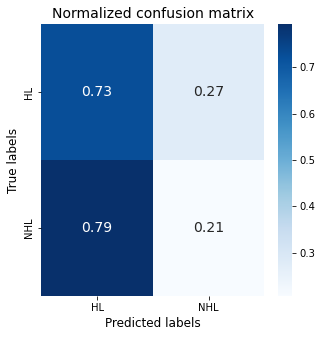

In [8]:
from sklearn.model_selection import cross_val_predict
dummy_scores = cross_val_predict ( clf_dummy, X_train, y_train, cv = 3, method = "predict_proba" )
y_train_pred = (dummy_scores[:,1] == 1)

from utils import precision_recall_scores
_ = precision_recall_scores ( y_train, y_train_pred, labels = ["HL", "NHL"], show_conf_matrix = True )

## 1st attempt: Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression

clf_logistic = LogisticRegression ( 
                                    penalty = "l2" ,
                                    class_weight = "balanced" ,
                                    solver = "liblinear" ,
                                    max_iter = 500 ,
                                    multi_class = "ovr" ,
                                  )

logistic_scores = cross_val_predict ( clf_logistic, X_train, y_train, cv = 3, method = "predict_proba" )

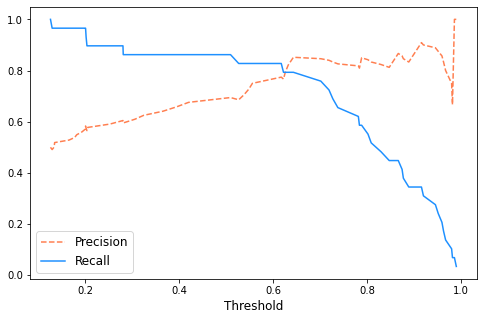

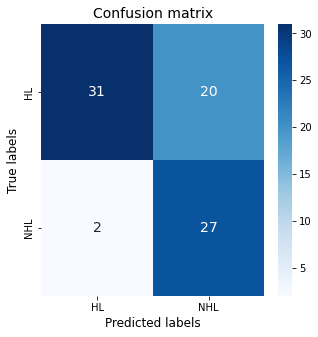

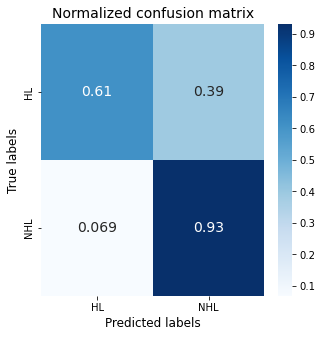

In [10]:
from utils import custom_predictions

y_train_pred_90, _ = custom_predictions (y_train, logistic_scores, recall_score = 0.9, show_curves = True)
_ = precision_recall_scores ( y_train, y_train_pred_90, labels = ["HL", "NHL"], show_conf_matrix = True )

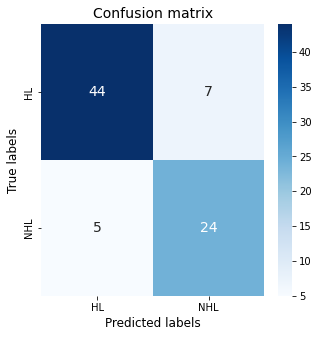

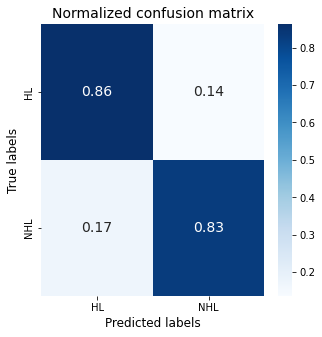

In [11]:
y_train_pred_80, _ = custom_predictions (y_train, logistic_scores, recall_score = 0.8)
_ = precision_recall_scores ( y_train, y_train_pred_80, labels = ["HL", "NHL"], show_conf_matrix = True )

### Automatic hyperparameters tuning

In [12]:
import optuna
optuna.logging.set_verbosity ( optuna.logging.ERROR )   # silence Optuna during trials study

### Return a set of trials studied by Optuna
def optuna_study (
                   model_name  : str ,
                   storage_dir : str ,
                   objective   : float ,
                   n_trials    : int = 10 ,
                   direction : str = "minimize"  , 
                   load_if_exists : bool = False ,
                 ):
  storage_path = "{}/{}.db" . format (storage_dir, model_name)
  storage_name = "sqlite:///{}" . format (storage_path)  

  if load_if_exists:
    pass
  elif not ( load_if_exists ) and os.path.isfile ( storage_path ):
    os.remove ( storage_path )

  study = optuna.create_study ( 
                                study_name = model_name ,
                                storage  = storage_name ,
                                load_if_exists = load_if_exists ,
                                direction = direction
                              )

  study . optimize ( objective, n_trials = n_trials )

  return study

In [13]:
from sklearn.metrics import roc_auc_score

def obj_logistic (trial):
  C = trial . suggest_float ( "C", 1e-3, 1e1, log = True )
  c_weights = trial . suggest_categorical ( "c_weights" , [None, "balanced"] )
  solver    = trial . suggest_categorical ( "solver", ["lbfgs", "liblinear"] )
  max_iter  = trial . suggest_int ( "max_iter", 500, 1000, log = True )

  model = LogisticRegression ( 
                               penalty = "l2" ,
                               C = C ,
                               class_weight = c_weights ,
                               solver = solver ,
                               max_iter = max_iter ,
                               multi_class = "ovr" ,
                             )
  
  y_scores = cross_val_predict ( model, X_train, y_train, cv = 3, method = "predict_proba" )
  return roc_auc_score ( y_train, y_scores[:,1] )


study_logistic = optuna_study (
                                model_name  = "bin_clf_logistic"  ,
                                storage_dir = "./storage" ,
                                objective = obj_logistic ,
                                n_trials  = 50 ,
                                direction = "maximize" ,
                                load_if_exists = False ,
                              )

In [14]:
df = study_logistic . trials_dataframe ( attrs = ("params", "value") )
df . sort_values ( by = "value", ascending = False ) . head()

,params_C,params_c_weights,params_max_iter,params_solver,value
25,0.751824,None,922,lbfgs,0.907370
49,0.833737,None,794,lbfgs,0.907370
41,0.840349,None,845,lbfgs,0.906694
33,1.724102,None,933,lbfgs,0.906694
38,1.661135,None,901,lbfgs,0.906018


In [15]:
best_params = study_logistic . best_params

clf_logistic = LogisticRegression ( 
                                    penalty = "l2" ,
                                    C = best_params["C"] ,
                                    class_weight = best_params["c_weights"] ,
                                    solver = best_params["solver"] ,
                                    max_iter = best_params["max_iter"] ,
                                    multi_class = "ovr" ,
                                  )

logistic_scores = cross_val_predict ( clf_logistic, X_train, y_train, cv = 3, method = "predict_proba" )

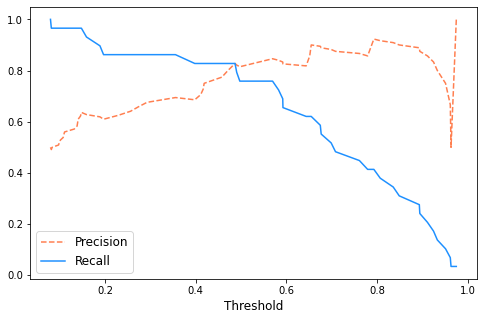

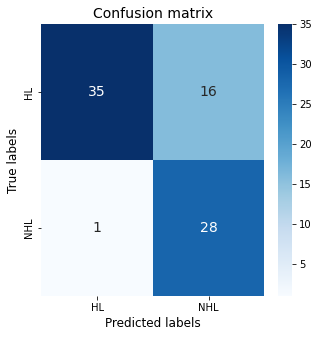

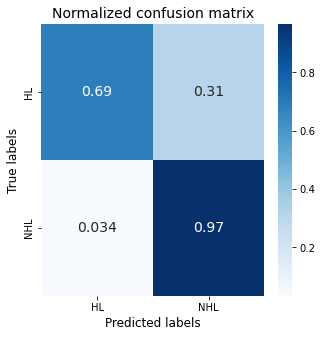

In [16]:
y_train_pred_95, _ = custom_predictions (y_train, logistic_scores, recall_score = 0.95, show_curves = True)
_ = precision_recall_scores ( y_train, y_train_pred_95, labels = ["HL", "NHL"], show_conf_matrix = True )

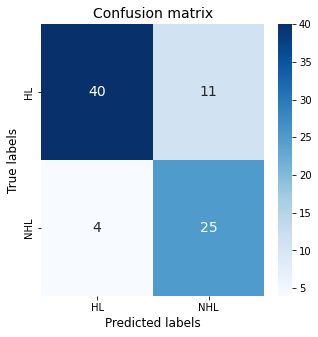

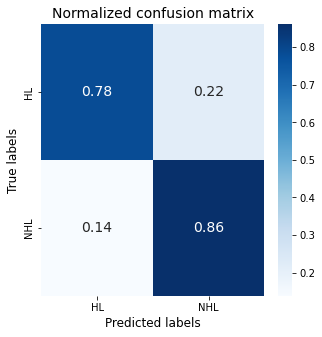

In [17]:
y_train_pred_90, _ = custom_predictions (y_train, logistic_scores, recall_score = 0.85)
_ = precision_recall_scores ( y_train, y_train_pred_90, labels = ["HL", "NHL"], show_conf_matrix = True )

## 2nd attempt: Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

clf_forest = RandomForestClassifier (
                                      n_estimators = 100 ,
                                      criterion = "gini" ,
                                      max_features = "sqrt" ,
                                      max_leaf_nodes = 10 ,
                                      max_depth = 5 ,
                                      class_weight = "balanced" ,
                                    )

forest_scores = cross_val_predict ( clf_forest, X_train, y_train, cv = 3, method = "predict_proba" )

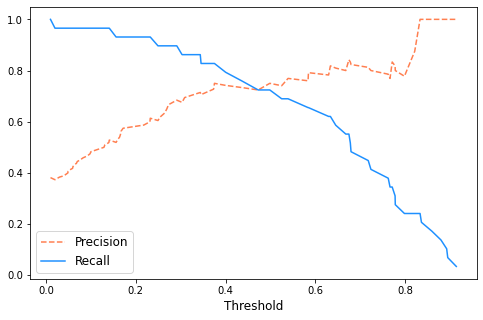

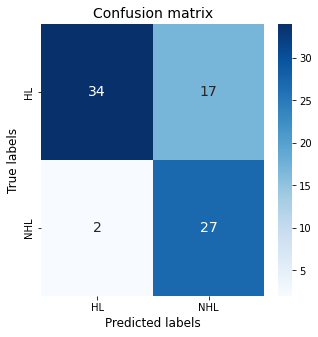

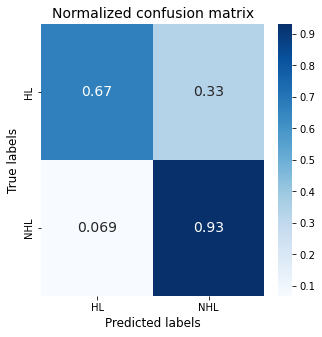

In [19]:
y_train_pred_90, _ = custom_predictions (y_train, forest_scores, recall_score = 0.90, show_curves = True)
_ = precision_recall_scores ( y_train, y_train_pred_90, labels = ["HL", "NHL"], show_conf_matrix = True )

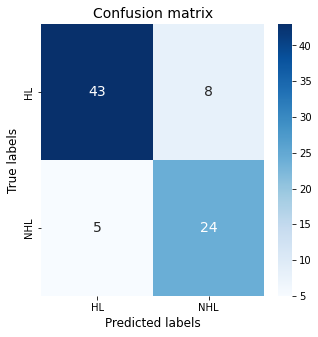

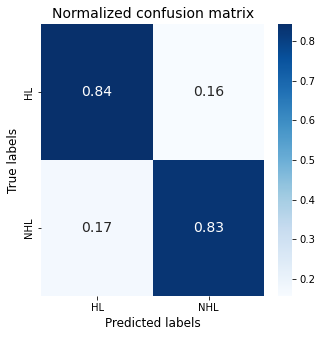

In [20]:
y_train_pred_80, _ = custom_predictions (y_train, forest_scores, recall_score = 0.80)
_ = precision_recall_scores ( y_train, y_train_pred_80, labels = ["HL", "NHL"], show_conf_matrix = True )

### Automatic hyperparameters tuning

In [21]:
def obj_forest (trial):
  n_estims  = trial . suggest_int ( "n_estims", 50, 500, log = True )
  criterion = trial . suggest_categorical ( "criterion", ["gini", "entropy"] )
  max_feats = trial . suggest_categorical ( "max_feats", ["sqrt", "log2", None] )
  max_leaf  = trial . suggest_int ( "max_leaf" , 2, 20 )
  max_depth = trial . suggest_int ( "max_depth", 1, 10 )
  c_weights = trial . suggest_categorical ( "c_weights", ["balanced", "balanced_subsample", None] )

  model = RandomForestClassifier ( 
                                   n_estimators = n_estims ,
                                   criterion = criterion   ,
                                   max_features = max_feats  ,
                                   max_leaf_nodes = max_leaf ,
                                   max_depth = max_depth ,
                                   class_weight = c_weights ,
                                 )
  
  y_scores = cross_val_predict ( model, X_train, y_train, cv = 3, method = "predict_proba" )
  return roc_auc_score ( y_train, y_scores[:,1] )


study_forest = optuna_study (
                              model_name  = "bin_clf_forest"  ,
                              storage_dir = "./storage" ,
                              objective = obj_forest ,
                              n_trials  = 50 ,
                              direction = "maximize" ,
                              load_if_exists = False ,
                            )

In [22]:
df = study_forest . trials_dataframe ( attrs = ("params", "value") )
df . sort_values ( by = "value", ascending = False ) . head()

,params_c_weights,params_criterion,params_max_depth,params_max_feats,params_max_leaf,params_n_estims,value
32,None,entropy,9,sqrt,18,221,0.884381
42,None,entropy,9,sqrt,16,291,0.878634
7,balanced,gini,5,sqrt,18,141,0.877958
9,balanced_subsample,entropy,4,sqrt,7,263,0.876944
6,balanced,gini,9,log2,8,75,0.874915


In [23]:
best_params = study_forest . best_params

clf_forest = RandomForestClassifier (
                                      n_estimators = best_params["n_estims"] ,
                                      criterion = best_params["criterion"]   ,
                                      max_features = best_params["max_feats"]  ,
                                      max_leaf_nodes = best_params["max_leaf"] ,
                                      max_depth = best_params["max_depth"] ,
                                      class_weight = best_params["c_weights"] ,
                                    )

forest_scores = cross_val_predict ( clf_forest, X_train, y_train, cv = 3, method = "predict_proba" )

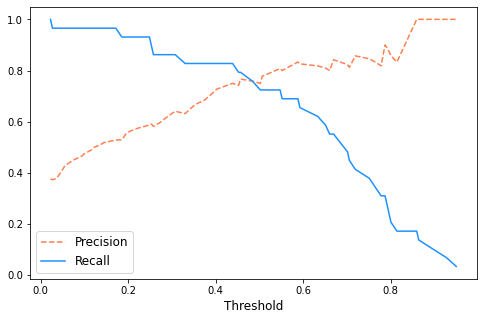

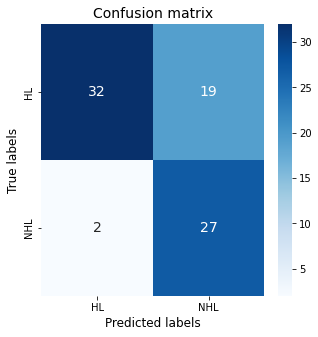

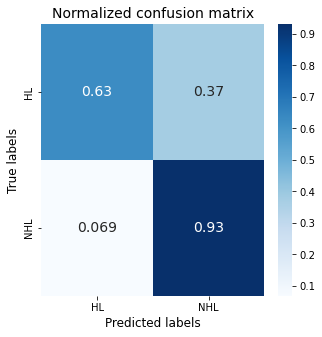

In [24]:
y_train_pred_90, _ = custom_predictions (y_train, forest_scores, recall_score = 0.90, show_curves = True)
_ = precision_recall_scores ( y_train, y_train_pred_90, labels = ["HL", "NHL"], show_conf_matrix = True )

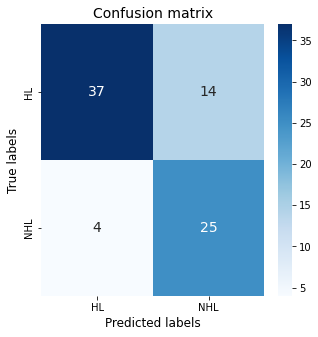

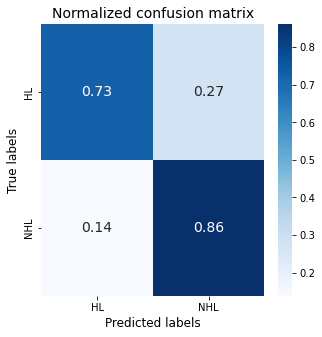

In [25]:
y_train_pred_85, _ = custom_predictions (y_train, forest_scores, recall_score = 0.85)
_ = precision_recall_scores ( y_train, y_train_pred_85, labels = ["HL", "NHL"], show_conf_matrix = True )

## 3rd attempt: Gradient Boosted Decision Trees

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gbdt = GradientBoostingClassifier (
                                        loss = "deviance" ,
                                        learning_rate = 0.2 ,
                                        n_estimators  = 100 ,
                                        criterion = "friedman_mse" ,
                                        max_features  = None , 
                                        max_leaf_nodes = 10 ,
                                        max_depth = 3       ,
                                      )

gbdt_scores = cross_val_predict ( clf_gbdt, X_train, y_train, cv = 3, method = "predict_proba" )

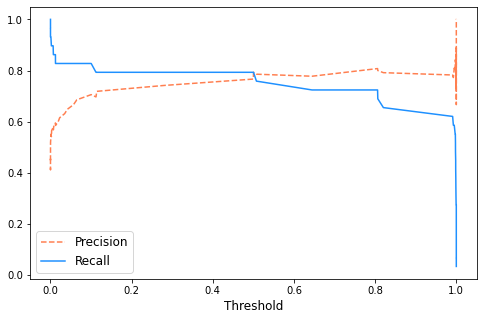

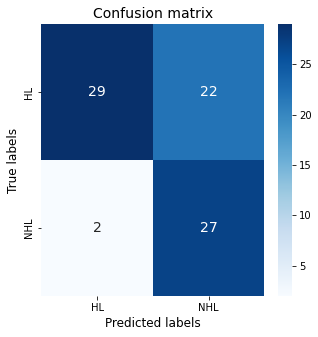

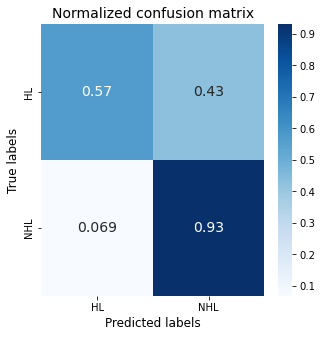

In [27]:
y_train_pred_90, _ = custom_predictions (y_train, gbdt_scores, recall_score = 0.90, show_curves = True)
_ = precision_recall_scores ( y_train, y_train_pred_90, labels = ["HL", "NHL"], show_conf_matrix = True )

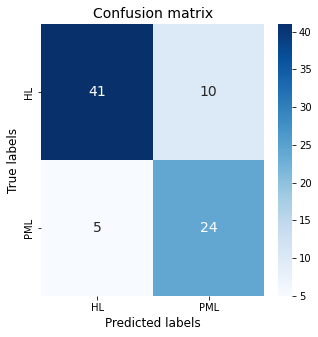

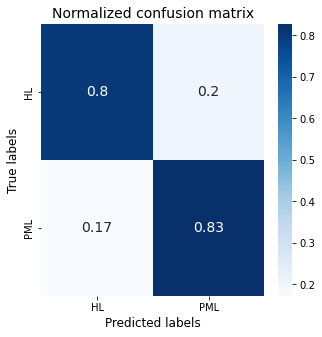

In [28]:
y_train_pred_80, _ = custom_predictions (y_train, gbdt_scores, recall_score = 0.80)
_ = precision_recall_scores ( y_train, y_train_pred_80, labels = ["HL", "PML"], show_conf_matrix = True )

### Automatic hyperparameters tuning

In [29]:
def obj_gbdt (trial):
  loss = trial . suggest_categorical ( "loss", ["deviance", "exponential"] )
  lr   = trial . suggest_float ( "lr", 0.05, 0.95, log = True )
  n_estims  = trial . suggest_int ( "n_estims", 50, 500, log = True )
  criterion = trial . suggest_categorical ( "criterion", ["friedman_mse", "mse"] )
  max_feats = trial . suggest_categorical ( "max_feats", ["sqrt", "log2", None] )
  max_leaf  = trial . suggest_int ( "max_leaf" , 2, 20 )
  max_depth = trial . suggest_int ( "max_depth", 1, 10 )

  model = GradientBoostingClassifier ( 
                                       loss = loss ,
                                       learning_rate =  lr , 
                                       n_estimators  =  n_estims , 
                                       criterion  =  criterion   ,
                                       max_features  = max_feats , 
                                       max_leaf_nodes = max_leaf ,
                                       max_depth = max_depth ,
                                     )
  
  y_scores = cross_val_predict ( model, X_train, y_train, cv = 3, method = "predict_proba" )
  return roc_auc_score ( y_train, y_scores[:,1] )


study_gbdt = optuna_study (
                          model_name  = "bin_clf_gbdt"  ,
                          storage_dir = "./storage" ,
                          objective = obj_gbdt ,
                          n_trials  = 50 ,
                          direction = "maximize" ,
                          load_if_exists = False ,
                        )

In [30]:
df = study_gbdt . trials_dataframe ( attrs = ("params", "value") )
df . sort_values ( by = "value", ascending = False ) . head()

,params_criterion,params_loss,params_lr,params_max_depth,params_max_feats,params_max_leaf,params_n_estims,value
21,friedman_mse,exponential,0.251565,9,log2,18,79,0.880325
7,mse,exponential,0.468753,8,log2,17,129,0.874239
3,friedman_mse,exponential,0.756248,8,log2,17,100,0.870521
0,friedman_mse,exponential,0.271645,8,log2,19,72,0.867478
5,mse,exponential,0.120440,8,log2,11,336,0.862745


In [31]:
best_params = study_gbdt . best_params

clf_gbdt = GradientBoostingClassifier (
                                        loss = best_params["loss"] ,
                                        learning_rate = best_params["lr"] ,
                                        n_estimators  = best_params["n_estims"]  ,
                                        criterion  =  best_params["criterion"]   ,
                                        max_features  = best_params["max_feats"] ,
                                        max_leaf_nodes = best_params["max_leaf"] ,
                                        max_depth = best_params["max_depth"] ,
                                      )

gbdt_scores = cross_val_predict ( clf_gbdt, X_train, y_train, cv = 3, method = "predict_proba" )

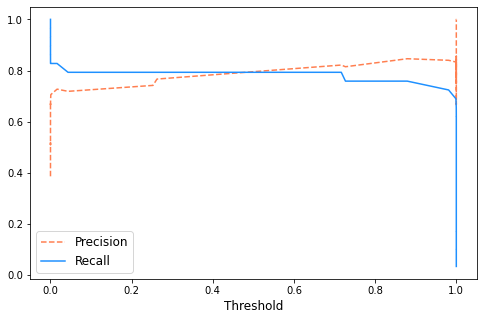

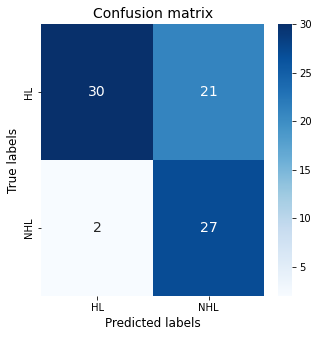

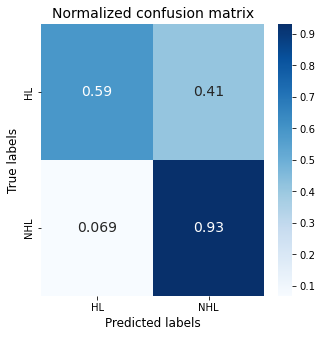

In [32]:
y_train_pred_90, _ = custom_predictions (y_train, gbdt_scores, recall_score = 0.90, show_curves = True)
_ = precision_recall_scores ( y_train, y_train_pred_90, labels = ["HL", "NHL"], show_conf_matrix = True )

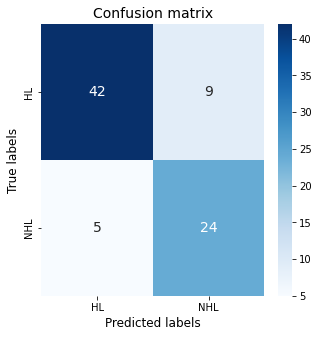

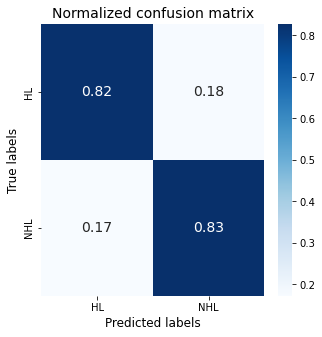

In [33]:
y_train_pred_80, _ = custom_predictions (y_train, gbdt_scores, recall_score = 0.80)
_ = precision_recall_scores ( y_train, y_train_pred_80, labels = ["HL", "NHL"], show_conf_matrix = True )

## 4th attempt: Models combination

In [34]:
from sklearn.ensemble import VotingClassifier

clf_ens = VotingClassifier (
                             estimators = [ ("logistic", clf_logistic), ("forest", clf_forest), ("gbdt", clf_gbdt) ],
                             voting = "soft"
                           )

ens_scores = cross_val_predict ( clf_ens, X_train, y_train, cv = 3, method = "predict_proba" )

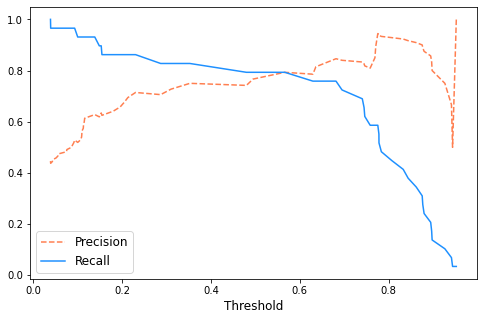

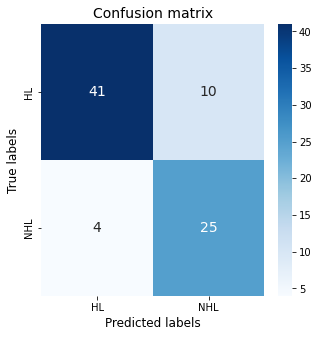

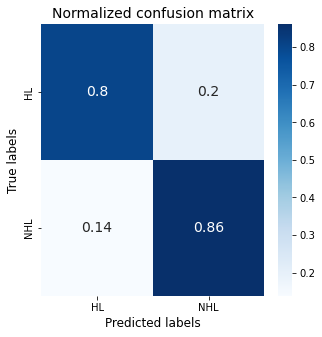

In [35]:
y_train_pred_85, _ = custom_predictions (y_train, ens_scores, recall_score = 0.85, show_curves = True)
_ = precision_recall_scores ( y_train, y_train_pred_85, labels = ["HL", "NHL"], show_conf_matrix = True )

## Models comparison

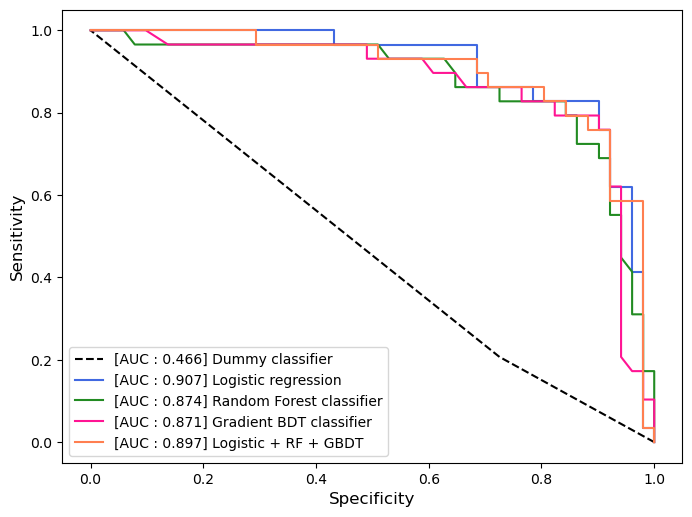

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

auc_scores = list()

model_scores = [dummy_scores[:,1], logistic_scores[:,1], forest_scores[:,1], gbdt_scores[:,1], ens_scores[:,1]]
colors = ["black", "royalblue", "forestgreen", "deeppink", "coral"]
styles = ["--", "-", "-", "-", "-"]
labels = ["Dummy classifier", "Logistic regression", "Random Forest classifier", "Gradient BDT classifier", "Logistic + RF + GBDT"]

plt.figure (figsize = (8,6), dpi = 100)
plt.xlabel ("Specificity", fontsize = 12)
plt.ylabel ("Sensitivity", fontsize = 12)
for score, col, stl, lbl in zip (model_scores, colors, styles, labels):
  auc = roc_auc_score ( y_train, score )
  auc_scores . append ( auc )
  fpr, tpr, _ = roc_curve ( y_train, score )
  plt.plot (1 - fpr, tpr, color = col, linestyle = stl, label = "[AUC : {:.3}] {}" .format (auc, lbl))
plt.legend (loc = "lower left", fontsize = 10)
plt.show()

## Performance evaluation

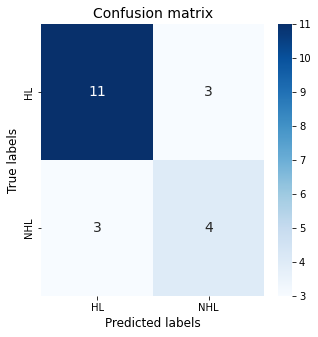

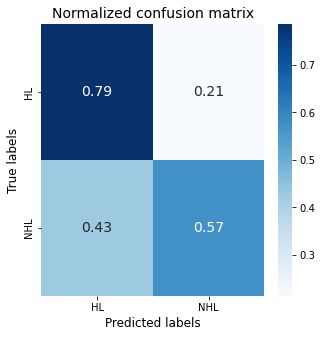

In [37]:
models = [clf_dummy, clf_logistic, clf_forest, clf_gbdt, clf_ens]

best_model = models [ np.argmax (auc_scores) ]

best_model . fit ( X_train, y_train )
best_scores = best_model . predict_proba ( X_train )
best_predictions, threshold = custom_predictions (y_train, best_scores, recall_score = 0.9)

y_test_proba = best_model . predict_proba ( X_test )
y_test_pred  = (y_test_proba[:,1] >= threshold)

_ = precision_recall_scores ( y_test, y_test_pred, labels = ["HL", "NHL"], show_conf_matrix = True )

## Model export

In [38]:
from datetime import datetime

timestamp = str (datetime.now()) . split (".") [0]
timestamp = timestamp . replace (" ","_")
version = ""
for time, unit in zip ( timestamp.split(":"), ["h","m","s"] ):
  version += time + unit   # YYYY-MM-DD_HHhMMmSSs

model_dir = "./models"
model_name = "bin_clf"
exp_model_file = f"{model_name}_{version}.pkl"
exp_model_path = os.path.join ( model_dir, exp_model_file )

pickle . dump ( best_model, open ( exp_model_path, "wb" ) )